# Deep Q-Network implementation
**References:**https://www.coursera.org/learn/practical-rl



In [5]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gym.core import ObservationWrapper
from gym.spaces import Box
from gym.spaces.box import Box
from gym.core import Wrapper
import cv2
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, InputLayer
from keras.models import Sequential
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame


(210, 160, 3)


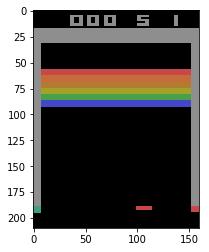

(64, 64, 1)


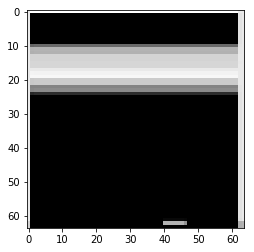

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

env = gym.make("BreakoutDeterministic-v0")
img = env.reset()
print(img.shape)
plt.imshow(img)
plt.show()

croped_img = img[30:195, 5:156, :]
croped_img = cv2.resize(croped_img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
croped_img_gray = cv2.cvtColor(croped_img, cv2.COLOR_RGB2GRAY)
croped_img_gray = croped_img_gray / 255.
print(croped_img_gray.reshape((64, 64, 1)).shape)
plt.imshow(croped_img_gray, cmap='gray')
plt.show()


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [0]:
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size, dtype=np.float32)

    def observation(self, img):
    
        croped_img = img[30:195, 5:156, :]
        croped_img = cv2.resize(croped_img, dsize=(self.img_size[0], self.img_size[1]), interpolation=cv2.INTER_CUBIC)
        croped_img_gray = cv2.cvtColor(croped_img, cv2.COLOR_RGB2GRAY)
        croped_img_gray = croped_img_gray / 255.
        croped_img_gray = croped_img_gray.reshape(self.img_size)
        
        return croped_img_gray.astype('float32')


In [0]:
#spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()


#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine")


Formal tests seem fine


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores N last images.

In [0]:
#from framebuffer import FrameBuffer
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape, dtype=np.float32)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=2, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(n_actions)
print(state_dim)

4
(64, 64, 2)


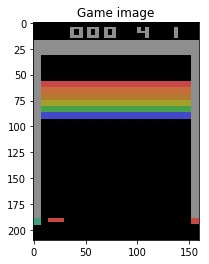

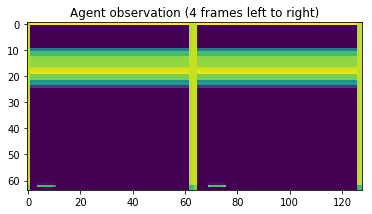

In [0]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Building a network


In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            self.Network = Sequential()
            self.Network.add(InputLayer(state_shape))
            self.Network.add(Conv2D(8, (3, 3), strides=(2,2) ,activation='relu'))
            self.Network.add(Conv2D(16, (3, 3), strides=(2,2), activation='relu'))
            self.Network.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu'))
            self.Network.add(Flatten())
            self.Network.add(Dense(128, activation='relu'))
            self.Network.add(Dense(n_actions, activation='linear'))
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        
        qvalues = self.Network(state_t)
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [0]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

W0621 12:52:01.248469 139665802729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 12:52:01.251095 139665802729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 12:52:01.266348 139665802729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Now let's try out our agent to see if it raises any errors.

In [0]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [0]:
evaluate(env, agent, n_games=1)

0.0

### Experience replay


#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [0]:
import random
from collections import deque

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._maxsize = size
        self._storage = deque([], size)

        
    def __len__(self):
        return len(self._storage)

    
    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        
        # add data to storage
        self._storage.append(data)
        
    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        batch_size = batch_size if batch_size <= len(self) else len(self)
        idxes = random.sample(self._storage, batch_size)
    
        states, actions, rewards, next_states, is_done = map(np.array, zip(*idxes))
        
        return states, actions, rewards, next_states, is_done


In [0]:
#from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [0]:
from IPython.display import clear_output
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    """
    # State at the beginning of rollout
    s = env.framebuffer
    total_reward = 0
    last_info = None
    for game in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        next_s, r, is_done, info = env.step(a)
        r = -10 if (last_info and last_info['ale.lives'] > info['ale.lives']) else r
        exp_replay.add(s, a, r, next_s, is_done)
        total_reward += r
        last_info = info
        if is_done:
            s = env.reset()
        else:
            s = next_s
    
    return total_reward

In [0]:
import time
exp_replay = ReplayBuffer(20000)
start = time.time()
play_and_record(agent, env, exp_replay, n_steps=1000)
print(f'for 1000 steps Time: {(time.time() - start)/60:.2f} min')
assert len(exp_replay) == 1000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    

print("Well done!")

for 1000 steps Time: 0.04 min
Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$





In [0]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [0]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    return assigns

In [0]:
copy_step = load_weigths_into_target_network(agent, target_network) 
sess.run(copy_step)
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
print("It works!")

It works!


### Learning with... Q-learning


In [0]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [0]:
# compute q-values for NEXT states with target network
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph) 

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = is_not_done * tf.reduce_max(next_qvalues_target, axis=1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma * next_state_values_target
#reference_qvalues = tf.where(is_done_ph, rewards_ph, reference_qvalues)

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-4).minimize(td_loss, var_list=agent.weights)

W0621 12:57:59.654993 139665802729344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
sess.run(tf.global_variables_initializer())

In [0]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!" # ignore if you're certain it's ok
print("Splendid!")

Splendid!


### Main loop

It's time to put everything together and see if it learns anything.

In [0]:
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [0]:
exp_replay = ReplayBuffer(10**5)
start = time.time()
play_and_record(agent, env, exp_replay, n_steps=10000)
print(f'n_teps=10000 take {(time.time() - start)/60:.2f} min')
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

n_teps=10000 take 0.36 min


buffer size = 100000, epsilon = 0.01000


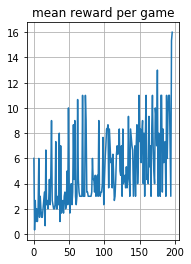

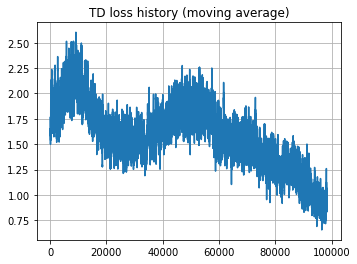

 98%|█████████▊| 98499/100000 [1:02:51<00:42, 35.28it/s]

10.4
it's ok to inturreput


In [0]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        copy_step = load_weigths_into_target_network(agent, target_network)
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.98, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        print(np.mean(mean_rw_history[-10:]))
        if np.mean(mean_rw_history[-10:]) > 10:
            print("it's ok to inturreput")
            break
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()
        
        